## SVM: MNIST Classification

```mermaid
flowchart TD

START([Start])
DATA[Load MNIST Dataset]
SPLIT[Split Data into Train and Test Sets]
SUBSET[Use a Subset of Data for Faster Training]
TRAIN[Train SVM Classifier]
PREDICT[Make Predictions on Test Set]
EVAL[Evaluate Model Performance using Confusion Matrix]
DISPLAY[Display Misclassified Images]
END([End])

subgraph Preprocessing
    SPLIT --> SUBSET
end
subgraph Model_Training
    SUBSET --> TRAIN
end
subgraph Evaluation
    TRAIN --> PREDICT
    PREDICT --> EVAL
    EVAL --> DISPLAY
end

START --> DATA
DATA --> SPLIT
DISPLAY --> END
```

This notebook will walk through the process of classifying handwritten digits from the MNIST dataset using a Support Vector Machine (SVM) classifier.

Datasource: [Kaggle MNIST Dataset](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv)

The main steps are:
1.  **Preprocess Data**: Split the data into training and testing sets and select a subset to speed up the training process.
2.  **Train Model**: Train an SVM classifier on the training data.
3.  **Evaluate Model**: Make predictions on the test set and evaluate the model's performance using a confusion matrix.
4.  **Analyze Results**: Display some of the images that were misclassified by the model to understand its failure modes.

### Setup Code

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_mnist_data():
    """
    Load the MNIST dataset from sklearn.
    IN: None
    OUT: X, pd.DataFrame of shape (70000, 784), digit images flattened into rows
         y, pd.Series of shape (70000,), digit labels
    """
    mnist = fetch_openml("mnist_784", version=1, as_frame=True)
    return mnist.data, mnist.target

In [3]:
if __name__ == "__main__":
    X, y = load_mnist_data()
    print("MNIST data loaded successfully.")
    print("X shape:", X.shape)
    print("y shape:", y.shape)

MNIST data loaded successfully.
X shape: (70000, 784)
y shape: (70000,)


### Task 1: Preprocessing

#### Subtask 1.1: Split Data into Train and Test Sets

Use `stratify` keyword argument in `train_test_split` to ensure that the class distribution is maintained in both training and testing sets.

Reference: [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [4]:
def split_data(X, y, train_proportion, test_proportion, random_state=None):
    """
    Split the data into training and testing sets.
    IN: X, pd.DataFrame of shape (70000, 784), digit images flattened into rows
        y, pd.Series of shape (70000,), digit labels
        train_proportion, float, proportion of samples for the training set
        test_proportion, float, proportion of samples for the test set
        random_state, int, seed for random number generator
    OUT: X_train, pd.DataFrame, training data
         X_test, pd.DataFrame, testing data
         y_train, pd.Series, training labels
         y_test, pd.Series, testing labels
    """
    if not np.isclose(train_proportion + test_proportion, 1.0):
        raise ValueError("train_proportion + test_proportion must equal 1.0")

    y_num = y.astype(int, copy=False)

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y_num,
        test_size=test_proportion,
        stratify=y_num,
        random_state=random_state,
        shuffle=True
    )
    return X_train, X_test, y_train, y_test

In [5]:
if __name__ == "__main__":
    train_proportion, test_proportion = 0.8, 0.2
    X_train, X_test, y_train, y_test = split_data(
        X,
        y,
        train_proportion=train_proportion,
        test_proportion=test_proportion,
        random_state=42,
    )
    print("Data split into training and testing sets.")
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)

Data split into training and testing sets.
X_train shape: (56000, 784)
X_test shape: (14000, 784)


#### Subtask 1.2: Use a Subset of Data for Faster Training

Use `stratified` keyword argument in `train_test_split` to ensure that the subset maintains the class distribution of the full dataset.

Reference: [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [6]:
def create_data_subset(X, y, size, random_state=None):
    """
    Create a subset of the data.
    IN: X, pd.DataFrame, data
        y, pd.Series, labels
        size, int, number of samples in the subset
        random_state, int, seed for random number generator
    OUT: X_subset, pd.DataFrame, subset of data
         y_subset, pd.Series, subset of labels
    """
    if size <= 0 or size > len(X):
        raise ValueError("size must be between 1 and len(X)")

    y_num = y.astype(int, copy=False)

    X_subset, _, y_subset, _ = train_test_split(
        X,
        y_num,
        train_size=size,
        stratify=y_num,
        random_state=random_state,
        shuffle=True
    )
    return X_subset, y_subset

In [7]:
if __name__ == "__main__":
    X_train_subset, y_train_subset = create_data_subset(
        X_train, y_train, size=5000, random_state=42
    )
    X_test_subset, y_test_subset = create_data_subset(
        X_test, y_test, size=1000, random_state=42
    )
    print("Created subsets for training and testing.")
    print("X_train_subset shape:", X_train_subset.shape)
    print("X_test_subset shape:", X_test_subset.shape)

Created subsets for training and testing.
X_train_subset shape: (5000, 784)
X_test_subset shape: (1000, 784)


### Task 2: Train SVM Classifier

In [8]:
def train_svm_classifier(X_train, y_train, svm_args, random_state=None):
    """
    Train an SVM classifier.
    IN: X_train, pd.DataFrame, training data
        y_train, pd.Series, training labels
        svm_args, dict, additional arguments for SVC
        random_state, int, seed for random number generator
    OUT: model, trained SVM classifier
    """
    params = dict(svm_args or {})
    if random_state is not None and "random_state" not in params:
        params["random_state"] = random_state

    model = SVC(**params)
    model.fit(X_train, y_train.astype(int, copy=False))
    return model

In [9]:
if __name__ == "__main__":
    svm_args = {
        "kernel": "rbf", 
        "C": 1.0,
        
    }
    svm_model = train_svm_classifier(
        X_train_subset, y_train_subset, svm_args, random_state=42
    )
    print("SVM model trained successfully.")

SVM model trained successfully.


### Task 3: Evaluate Model Performance

#### Subtask 3.1: Make Predictions on Test Set

In [10]:
def make_predictions(model, X_test):
    """
    Make predictions on the test set.
    IN: model, trained SVM classifier
        X_test, pd.DataFrame, testing data
    OUT: y_pred, np.ndarray, predicted labels
    """
    y_pred = model.predict(X_test)
    return y_pred

In [11]:
if __name__ == "__main__":
    y_pred = make_predictions(svm_model, X_test_subset)
    print("Predictions made on the test set.")

Predictions made on the test set.


#### Subtask 3.2: Evaluate Model Performance using Confusion Matrix

In [12]:
def compute_confusion_matrix(y_true, y_pred):
    """
    Compute the confusion matrix.
    IN: y_true, pd.Series, true labels
        y_pred, np.ndarray, predicted labels
    OUT: cm, np.ndarray, confusion matrix, each entry cm[i][j] is the count of samples with true label i predicted as label j
    """
    labels = np.unique(np.concatenate([np.asarray(y_true).astype(int), np.asarray(y_pred).astype(int)]))
    cm = confusion_matrix(np.asarray(y_true).astype(int), np.asarray(y_pred).astype(int), labels=labels)
    return cm

Reference:
- [sns.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

In [13]:
def plot_confusion_matrix(cm):
    """
    Plot the confusion matrix.
    IN: cm, np.ndarray, confusion matrix
    OUT: None
    """
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

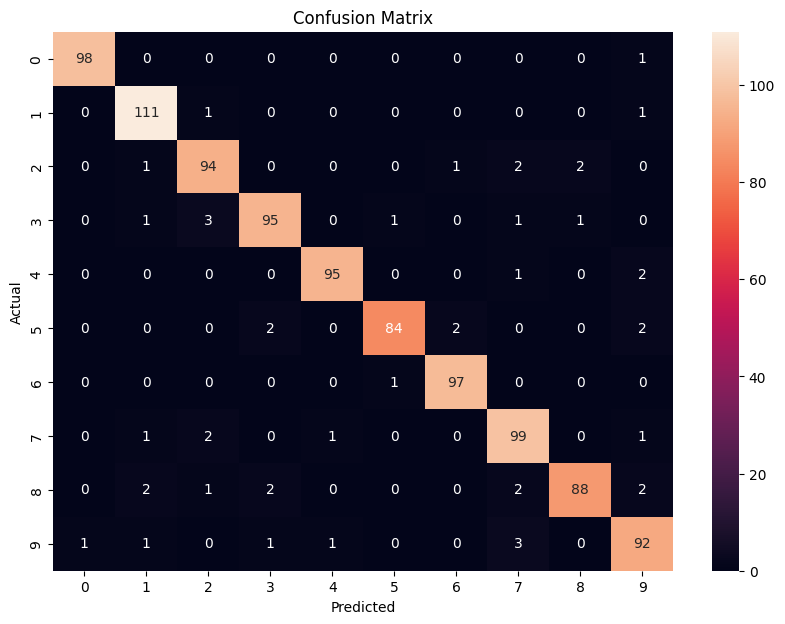

In [14]:
if __name__ == "__main__":
    cm = compute_confusion_matrix(y_test_subset, y_pred)
    plot_confusion_matrix(cm)

### Subtask 3.3: Display Misclassified Images

In [15]:
def find_misclassified_images(y_true, y_pred):
    """
    Find misclassified images.
    IN: y_true, pd.Series, true labels
        y_pred, np.ndarray, predicted labels
    OUT: misclassified_indices, list of int, indices of misclassified images in X_test
    """
    y_true_arr = np.asarray(y_true).astype(int)
    y_pred_arr = np.asarray(y_pred).astype(int)
    misclassified_indices = np.where(y_true_arr != y_pred_arr)[0].tolist()
    return misclassified_indices

To show an image using `matplotlib`, you can reshape the flat array of pixel values back into a 28x28 array and use `plt.imshow()` to display it.

```python
plt.imshow(image_array.reshape(28, 28), cmap='gray')
```

In [16]:
def display_misclassified_images(X_test, y_test, y_pred, misclassified_indices):
    """
    Display some of the misclassified images.
    IN: X_test, pd.DataFrame, testing data
        y_test, pd.Series, true labels
        y_pred, np.ndarray, predicted labels
        misclassified_indices, list of int, indices of misclassified images in X_test
    OUT: None
    """
    fig_num = len(misclassified_indices)
    row_num = np.sqrt(fig_num).astype(int)
    col_num = np.ceil(fig_num / row_num).astype(int)
    plt.figure(figsize=(2 * col_num, 2 * row_num))
    for i, index in enumerate(misclassified_indices):
        plt.subplot(row_num, col_num, i + 1)
        image_array = np.asarray(X_test.iloc[index])
        plt.imshow(image_array.reshape(28, 28), cmap='gray')
        plt.title(f"True: {y_test.iloc[index]}, Pred: {y_pred[index]}")
        plt.axis("off")
    plt.show()

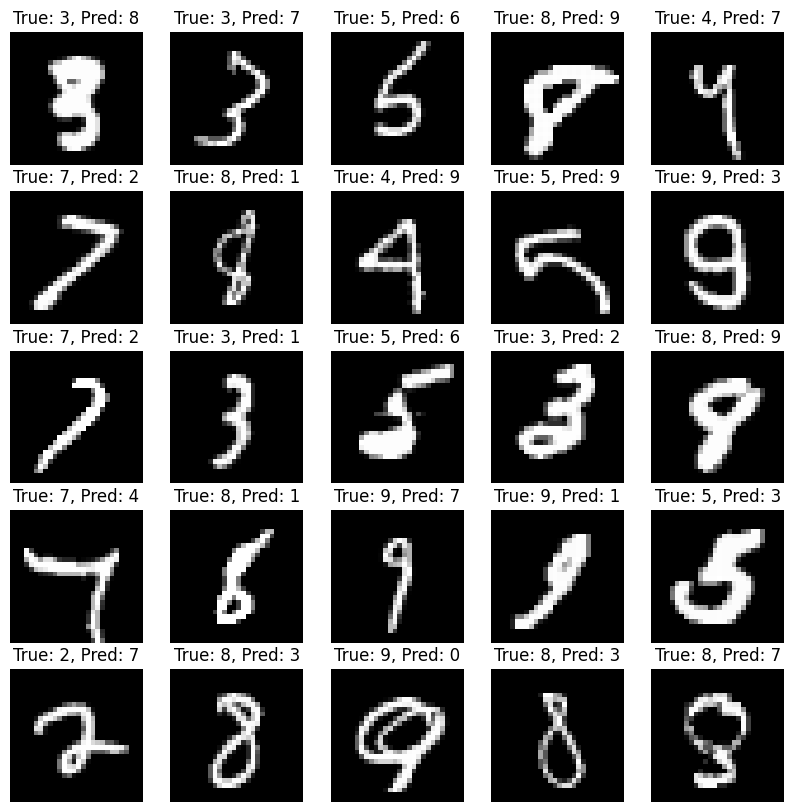

In [17]:
if __name__ == "__main__":
    misclassified_indices = find_misclassified_images(y_test_subset, y_pred)
    display_misclassified_images(
        X_test_subset, y_test_subset, y_pred, misclassified_indices[:25]
    )